In [1]:
import itertools
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.model.deepar import DeepAREstimator
from gluonts.model.forecast import SampleForecast
from gluonts.trainer import Trainer
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator


from gluonts.evaluation.backtest import make_evaluation_predictions

In [48]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AdhocTransform,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
    TransformedDataset
)

In [3]:
from gluonts.model.predictor import Predictor

In [3]:
from src.gluonts_data import MockGluonData

In [4]:
mgd = MockGluonData()

In [6]:
full_df = mgd.full_df

In [8]:
freq = mgd.freq

In [9]:
break_date = "2017-04-01"

In [10]:
dynamic_real_cols = mgd.dynamic_real_cols
static_real_cols = mgd.static_real_cols
dynamic_cat_cols = mgd.dynamic_cat_cols
static_cat_cols = mgd.static_cat_cols

target_col = mgd.target_col
date_col = mgd.date_col

In [12]:
def get_list_dataset(df):

    ds = ListDataset(
        [
            {
                FieldName.TARGET: gdf.loc[:, target_col].values,
                FieldName.START: gdf.loc[:, date_col].min(),
                FieldName.FEAT_DYNAMIC_REAL: list(
                    gdf.loc[:, dynamic_real_cols].values.T
                ),
                FieldName.FEAT_DYNAMIC_CAT: list(gdf.loc[:, dynamic_cat_cols].values.T),
                FieldName.FEAT_STATIC_CAT: gid,
                FieldName.FEAT_STATIC_REAL: gdf.loc[:, static_real_cols]
                .iloc[0, :]
                .values,
            }
            for gid, gdf in df.groupby(static_cat_cols)
        ],
        freq=freq,
    )

    static_cat_nums = df.loc[:, static_cat_cols].nunique().tolist()
    
    return ds, static_cat_nums

In [13]:
train_df = full_df.loc[lambda df: df[date_col] < break_date, :]
test_df = full_df.loc[lambda df: df[date_col] >= break_date, :]

In [14]:
train_ds, static_cat_nums = get_list_dataset(train_df)

In [16]:
prediction_length = 6
context_length = 15

In [17]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq=freq,
    context_length=context_length,
    use_feat_dynamic_real=len(dynamic_real_cols) > 0,
    use_feat_static_cat=len(static_cat_cols) > 0,
    use_feat_static_real=len(static_real_cols) > 0,
    cardinality=static_cat_nums,
    scaling=True,
    trainer=Trainer(ctx="cpu",
                    epochs=15,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

In [18]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:09<00:00, 11.09it/s, epoch=15/15, avg_epoch_loss=-1.18]


In [95]:
prediction_length = predictor.prediction_length

In [88]:
test_df = full_df.loc[
    lambda df: (
        df[date_col] >= pd.Timestamp(break_date) - dt.timedelta(context_length)
    ),
    :,
]

In [125]:
from tqdm.notebook import tqdm

In [141]:
context_length = 15
context_length = 10

In [142]:
pred_dfs = []

for act_test_start_date in tqdm(pd.date_range(
    test_df[date_col].min() + dt.timedelta(context_length),
    test_df[date_col].max() - dt.timedelta(prediction_length),
)):
    act_test_ds, _ = test_df.loc[
        lambda df: (
            (df[date_col] >= pd.Timestamp(act_test_start_date) - dt.timedelta(context_length)) & 
            (df[date_col] < pd.Timestamp(act_test_start_date) + dt.timedelta(prediction_length))
        ),
        :,
    ].pipe(get_list_dataset)

    def truncate_target(data):
        return {**data, "target": data["target"][..., : -prediction_length]}


    dataset_trunc = TransformedDataset(
        act_test_ds, transformations=[AdhocTransform(truncate_target)]
    )

    forecasts = predictor.predict(dataset_trunc, num_samples=500)

    for forecast_entry, test_entry in zip(forecasts, act_test_ds):
        pred_dfs.append(
            pd.DataFrame(
                {
                    "pred_y": forecast_entry.mean,
                    "test_y": test_entry[FieldName.TARGET][-prediction_length:],
                    "live": range(-1, -prediction_length - 1, -1),
                    date_col: pd.date_range(
                        start=test_entry[FieldName.START],
                        freq=freq,
                        periods=len(test_entry[FieldName.TARGET]),
                    )[-prediction_length:],
                }
            ).assign(
                **{
                    k: v
                    for k, v in zip(static_cat_cols, test_entry[FieldName.FEAT_STATIC_CAT])
                }
            )
        )

In [145]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 50
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [146]:
test_ds, _ = get_list_dataset(full_df)

In [147]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,   # number of sample paths we want for evaluation
)

In [148]:
forecasts = list(forecast_it)
tss = list(ts_it)

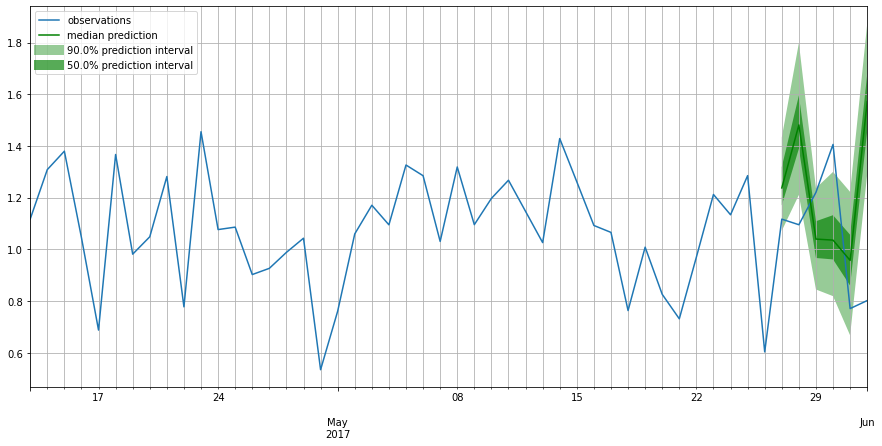

In [149]:
forecast_ind = 1
ts_entry = tss[forecast_ind]
forecast_entry = forecasts[forecast_ind]
plot_prob_forecasts(ts_entry, forecast_entry)

In [150]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [151]:
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 265.79it/s]


In [152]:
agg_metrics

{'MSE': 0.10245893125732741,
 'abs_error': 15.80133605003357,
 'abs_target_sum': 62.12149429321289,
 'abs_target_mean': 1.0353582382202149,
 'seasonal_error': 0.23136626218044962,
 'MASE': 1.1840738620003857,
 'MAPE': 0.2738717572435321,
 'sMAPE': 0.24823743552289437,
 'OWA': nan,
 'MSIS': 9.356947931462845,
 'QuantileLoss[0.1]': 8.834828704595566,
 'Coverage[0.1]': 0.16666666666666666,
 'QuantileLoss[0.5]': 15.80133605003357,
 'Coverage[0.5]': 0.6,
 'QuantileLoss[0.9]': 7.251801204681395,
 'Coverage[0.9]': 0.9333333333333332,
 'RMSE': 0.3200920668453491,
 'NRMSE': 0.3091606895363953,
 'ND': 0.25436181517867884,
 'wQuantileLoss[0.1]': 0.14221854778468873,
 'wQuantileLoss[0.5]': 0.25436181517867884,
 'wQuantileLoss[0.9]': 0.11673578182863661,
 'mean_wQuantileLoss': 0.1711053815973347,
 'MAE_Coverage': 0.06666666666666661}

In [153]:
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [155]:
base_shift = mgd.base_shift

In [156]:
tree_df = (
    full_df.groupby(static_cat_cols)
    .apply(
        lambda df: pd.concat(
            [
                df.loc[:, [target_col, date_col]],
                *[
                    df.drop(date_col, axis=1)
                    .shift(base_shift + p)
                    .rename(columns=lambda s: f"LAG_{p}_{s}")
                    for p in range(3)
                ],
            ],
            axis=1,
        )
    )
    .dropna()
)

In [157]:
tree_train_df = tree_df.loc[lambda df: df[date_col] < break_date, :]
tree_test_df = tree_df.loc[lambda df: df[date_col] >= break_date, :]

In [158]:
tree_model = lgbm.LGBMRegressor().fit(
    tree_train_df.drop([target_col, date_col], axis=1), tree_train_df.loc[:, target_col]
)

In [159]:
test_pred = tree_model.predict(tree_test_df.drop([target_col, date_col], axis=1))

In [160]:
mean_absolute_error(test_pred, tree_test_df.loc[:, target_col]), mean_squared_error(
    test_pred, tree_test_df.loc[:, target_col]
)

(0.17668013248424422, 0.04942814205299055)

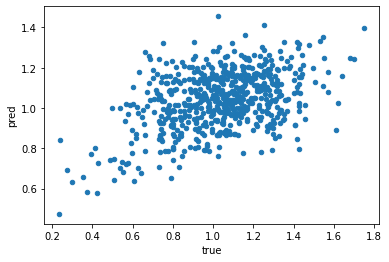

In [161]:
pd.DataFrame(
    {"pred": test_pred, "true": tree_test_df.loc[:, target_col].values}
).plot.scatter(x="true", y="pred")

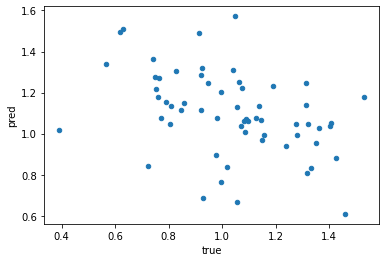

In [162]:
pd.concat(
    [
        pd.DataFrame(
            {
                "pred": fc.samples.mean(axis=0),
                "true": truevals.loc[break_date:, :]
                .iloc[:prediction_length, :]
                .values[:, 0],
            }
        )
        for fc, truevals in zip(forecasts, tss)
        if truevals.index[-prediction_length] > pd.Timestamp(break_date)
    ]
).plot.scatter(x="true", y="pred")